# Fish-DSCS associations at Cypress Point, Monterey Peninsula, CA

### Data

The data are in two .csv files exported from the Microsoft Access database for the MARE ROV surveys from 2005–2019. `Fish_1sec_2005-2019_2-3-2021_CP.csv` contains fish species data and `Invert_1sec_2005-2019_2-3-2021_CP.csv` contains invertebrate taxonomic data.

In [192]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import pingouin as pg
from scipy import stats
from scipy import linalg

In [2]:
#Import data and combine date and time columns into new date-time column
fish = pd.read_csv("Fish_1sec_205-2019_2-3-2021_CP.csv", parse_dates=[['Survey_Date', 'TC']])
inverts = pd.read_csv("Invert_1sec_2005-2019_2-3-2021_CP.csv", parse_dates=[['Survey_Date', 'TC']])

In [3]:
#Remove unusable data and remove 2009 survey from fish data (because there is no corresponding 2009 invertebrate data)
fish = fish[fish['Unusable_Data']!='X']
fish = fish[fish['Year']!='2009']
inverts = inverts[inverts['Unusable_Data']!='X']

In [4]:
#Add column with fish/invert identifier
fish['Group'] = 'FISH'
inverts['Group'] = 'INVERT'

In [5]:
#Create subset that only includes deep-sea coral/sponge (DSCS) records
DSCS = inverts[inverts['SpeciesName'].isin(['Unidentified Porifera (boot)', 'Unidentified Porifera or Bryozoa', 'Swiftia spauldingi', 'Unidentified Porifera (branched)', 'Anthomastus ritteri /syn./ Heteropolypus ritteri', 'Leptogorgia chilensis', 'Stylaster californicus', 'Tethya aurantia', 'Unidentified Porifera', 'Unidentified Porifera (nipple)', 'Craniella arb', 'Unidentified Porifera (vase)', 'Unidentified Porifera (lobed)'])]

In [6]:
#Combine fish and deep-sea coral/sponge (DSCS) datasets and sort
df = pd.concat([fish, DSCS])
df = df.sort_values(by = ['Survey_Date_TC'])

Next we will create a new column based on habitat type. We shift the habitat type column by one row, then use boolean logic to differentiate where new habitat patches (continuous sets of data within the same habitat type) occur. Values in the resulting `Habitat_patch` column can be interpreted as the habitat patch identifiers. See [this resource](https://towardsdatascience.com/pandas-dataframe-group-by-consecutive-same-values-128913875dba).

In [7]:
df['Habitat_shift'] = df['Habitat_Type'].shift()
df['shift!=orig'] = np.where(df['Habitat_shift']!=df['Habitat_Type'],True,False)
df['Habitat_patch'] = np.cumsum(df['shift!=orig'])

Next we will assign an identifier to each row based on the transect that it is in using the same technique as the cell above.

In [8]:
df['Transect_shift'] = df["Transect_ID"].shift()
df['transectshift!=orig'] = np.where(df['Transect_shift']!=df["Transect_ID"],True,False)
df['Transect_no'] = np.cumsum(df['transectshift!=orig'])

Next we will group the count data by habitat patch. For the simplest preliminary analysis, we will sum all fish for each habitat patch and regress this sum against the sum of all DSCS.

In [9]:
dfgroup = df.groupby(by=['Habitat_patch','Habitat_Type','SpeciesName', 'Group']).agg({'Count':sum})
dfgroup.reset_index(inplace = True)
dfgroup

,Habitat_patch,Habitat_Type,SpeciesName,Group,Count
0,1,Soft,Sebastes semicinctus,FISH,3.00
1,1,Soft,Unidentified Pleuronectidae,FISH,4.00
2,1,Soft,Unidentified Sebastes sp.,FISH,3.00
3,2,Hard,Unidentified Porifera (boot),INVERT,1.00
4,2,Hard,Unidentified Sebastes sp.,FISH,6.00
...,...,...,...,...,...
2946,864,Hard,Sebastes mystinus or diaconus,FISH,13.00
2947,864,Hard,Sebastes rosaceus,FISH,1.00
2948,864,Hard,Stylaster californicus,INVERT,97.92
2949,864,Hard,Unidentified Porifera (lobed),INVERT,2.00


In [10]:
dfgroup2 = dfgroup.pivot(index = ['Habitat_patch', 'Habitat_Type'], columns = 'SpeciesName', values = 'Count')
dfgroup2.reset_index(inplace = True)
dfgroup2

SpeciesName,Habitat_patch,Habitat_Type,Ammodytes hexapterus,Anarrhichthys ocellatus,Anthomastus ritteri /syn./ Heteropolypus ritteri,Brachyistius frenatus,Craniella arb,Embiotoca lateralis,Hexagrammos decagrammus,Hydrolagus colliei,...,Unidentified Porifera (nipple),Unidentified Porifera (vase),Unidentified Porifera or Bryozoa,Unidentified Sebastes sp.,Unidentified Sebastomus sp.,Unidentified schooling pelagic fish,Unidentified small benthic fish,Young of year (<10 cm Sebastes sp.),Zalembius rosaceus,Zaniolepis frenata
0,1,Soft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN
2,3,Hard_Mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN
4,5,Hard_Mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,Hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,861,Hard_Mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861,862,Hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,863,Soft_Mixed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Create abundance columns
dfgroup2 = dfgroup2.fillna(0)
dfgroup2['Sponge_abundance'] = dfgroup2['Unidentified Porifera (boot)']+dfgroup2['Unidentified Porifera or Bryozoa']+dfgroup2['Unidentified Porifera (branched)']+dfgroup2['Tethya aurantia']+dfgroup2['Unidentified Porifera']+dfgroup2['Unidentified Porifera (nipple)']+dfgroup2['Craniella arb']+dfgroup2['Unidentified Porifera (vase)']+dfgroup2['Unidentified Porifera (lobed)']
dfgroup2['Coral_abundance'] = dfgroup2['Swiftia spauldingi']+dfgroup2['Anthomastus ritteri /syn./ Heteropolypus ritteri']+dfgroup2['Leptogorgia chilensis']+dfgroup2['Stylaster californicus']
dfgroup2['DSCS_abundance'] = dfgroup2['Unidentified Porifera (boot)']+dfgroup2['Unidentified Porifera or Bryozoa']+dfgroup2['Unidentified Porifera (branched)']+dfgroup2['Tethya aurantia']+dfgroup2['Unidentified Porifera']+dfgroup2['Unidentified Porifera (nipple)']+dfgroup2['Craniella arb']+dfgroup2['Unidentified Porifera (vase)']+dfgroup2['Unidentified Porifera (lobed)']+dfgroup2['Swiftia spauldingi']+dfgroup2['Anthomastus ritteri /syn./ Heteropolypus ritteri']+dfgroup2['Leptogorgia chilensis']+dfgroup2['Stylaster californicus']
dfgroup2['Demosponge_abundance'] = dfgroup2['Tethya aurantia']+dfgroup2['Craniella arb']+dfgroup2['Unidentified Porifera (nipple)']
dfgroup2['Hexactinellid_abundance'] = dfgroup2['Unidentified Porifera (boot)']+dfgroup2['Unidentified Porifera (vase)']
dfgroup2['Gorgonian_abundance'] = dfgroup2['Swiftia spauldingi']+dfgroup2['Leptogorgia chilensis']
dfgroup2['Fish_abundance'] = dfgroup2['Ammodytes hexapterus']+dfgroup2['Anarrhichthys ocellatus']+dfgroup2['Brachyistius frenatus']+dfgroup2['Embiotoca lateralis']+dfgroup2['Hexagrammos decagrammus']+dfgroup2['Hydrolagus colliei']+dfgroup2['Ophiodon elongatus']+dfgroup2['Oxyjulis californica']+dfgroup2['Oxylebius pictus']+dfgroup2['Parophrys vetulus']+dfgroup2['Phanerodon atripes']+dfgroup2['Phanerodon furcatus']+dfgroup2['Raja stellulata']+dfgroup2['Rathbunella hypoplecta']+dfgroup2['Rhacochilus vacca']+dfgroup2['Schooling (10-15 cm Sebastes sp.)']+dfgroup2['Scorpaenichthys marmoratus']+dfgroup2['Sebastes atrovirens']+dfgroup2['Sebastes carnatus']+dfgroup2['Sebastes caurinus']+dfgroup2['Sebastes chlorostictus']+dfgroup2['Sebastes constellatus']+dfgroup2['Sebastes dallii']+dfgroup2['Sebastes elongatus'] + dfgroup2['Sebastes entomelas'] + dfgroup2['Sebastes helvomaculatus'] + dfgroup2['Sebastes hopkinsi'] + dfgroup2['Sebastes hopkinsi or entomelas'] + dfgroup2['Sebastes maliger'] + dfgroup2['Sebastes melanops'] + dfgroup2['Sebastes miniatus'] + dfgroup2['Sebastes mystinus'] + dfgroup2['Sebastes mystinus or diaconus'] + dfgroup2['Sebastes nebulosus'] + dfgroup2['Sebastes nigrocinctus'] + dfgroup2['Sebastes ovalis'] + dfgroup2['Sebastes paucispinis'] + dfgroup2['Sebastes pinniger'] + dfgroup2['Sebastes pinniger or miniatus'] + dfgroup2['Sebastes rosaceus'] + dfgroup2['Sebastes ruberrimus'] + dfgroup2['Sebastes semicinctus'] + dfgroup2['Sebastes serranoides or flavidus'] + dfgroup2['Sebastes wilsoni'] + dfgroup2['Semicossyphus pulcher'] + dfgroup2['Unidentified Agonidae'] + dfgroup2['Unidentified Citharichthys sp.'] + dfgroup2['Unidentified Cottidae'] + dfgroup2['Unidentified Embiotocidae'] + dfgroup2['Unidentified Pleuronectidae'] + dfgroup2['Unidentified Sebastes sp.'] + dfgroup2['Unidentified Sebastomus sp.'] + dfgroup2['Unidentified schooling pelagic fish'] + dfgroup2['Unidentified small benthic fish'] + dfgroup2['Young of year (<10 cm Sebastes sp.)'] + dfgroup2['Zalembius rosaceus'] + dfgroup2['Zaniolepis frenata']
dfgroup2

SpeciesName,Habitat_patch,Habitat_Type,Ammodytes hexapterus,Anarrhichthys ocellatus,Anthomastus ritteri /syn./ Heteropolypus ritteri,Brachyistius frenatus,Craniella arb,Embiotoca lateralis,Hexagrammos decagrammus,Hydrolagus colliei,...,Young of year (<10 cm Sebastes sp.),Zalembius rosaceus,Zaniolepis frenata,Sponge_abundance,Coral_abundance,DSCS_abundance,Demosponge_abundance,Hexactinellid_abundance,Gorgonian_abundance,Fish_abundance
0,1,Soft,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,10.00
1,2,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,1.0,0.00,1.00,0.0,1.0,0.0,7.00
2,3,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,8.00
3,4,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,3.00
4,5,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,1.0,81.65,82.65,0.0,0.0,0.0,3.00
860,861,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1.00
861,862,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,4.0,165.43,169.43,1.0,0.0,0.0,3.00
862,863,Soft_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2.00


In [12]:
#Create fish richness column
dfgroup2 = dfgroup2.replace(0, np.nan)
dfgroup2['Fish_richness'] = dfgroup2.count(1)
dfgroup2 = dfgroup2.fillna(0)
dfgroup2

SpeciesName,Habitat_patch,Habitat_Type,Ammodytes hexapterus,Anarrhichthys ocellatus,Anthomastus ritteri /syn./ Heteropolypus ritteri,Brachyistius frenatus,Craniella arb,Embiotoca lateralis,Hexagrammos decagrammus,Hydrolagus colliei,...,Zalembius rosaceus,Zaniolepis frenata,Sponge_abundance,Coral_abundance,DSCS_abundance,Demosponge_abundance,Hexactinellid_abundance,Gorgonian_abundance,Fish_abundance,Fish_richness
0,1,Soft,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,10.00,6
1,2,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00,1.00,0.0,1.0,0.0,7.00,9
2,3,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,8.00,4
3,4,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,3.00,5
4,5,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,7.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,81.65,82.65,0.0,0.0,0.0,3.00,10
860,861,Hard_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1.00,4
861,862,Hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,165.43,169.43,1.0,0.0,0.0,3.00,12
862,863,Soft_Mixed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2.00,4


We will use function `diversity` in package `EcoPy` to calculate Simpson's diversity index for fish. I ran into errors installing `EcoPy` and reproduced only the `diversity.py` function from the [GitHub repository](https://github.com/Auerilas/ecopy) instead.

In [26]:
from diversity import diversity

In [204]:
dfgroup2['Fish_simpson'] = diversity(dfgroup2.iloc[:,2:71], method='simpson')
dfgroup2
dfgroup2.to_csv('CP_data.csv')

#Issue: Simpson's is only supposed to range from 0 to 1

In [71]:
#Examine data for normality
normality = pg.normality(dfgroup2)
pd.set_option('display.max_rows', None)
normality
#Data is not normally distributed

,W,pval,normal
SpeciesName,,,
Habitat_patch,0.954792,1.193451e-15,False
Ammodytes hexapterus,0.013449,0.000000e+00,False
Anarrhichthys ocellatus,0.047467,0.000000e+00,False
Anthomastus ritteri /syn./ Heteropolypus ritteri,0.013449,0.000000e+00,False
Brachyistius frenatus,0.013449,0.000000e+00,False
Craniella arb,0.114798,0.000000e+00,False
Embiotoca lateralis,0.057096,0.000000e+00,False
Hexagrammos decagrammus,0.167180,0.000000e+00,False
Hydrolagus colliei,0.078772,0.000000e+00,False


We will first use Spearman rank correlations to look for covariance between fish and invertebrate diversity metrics.

In [178]:
#Fish total abundance vs. invertebrate parameters
Fab_DSCSab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['DSCS_abundance'])
Fab_Spongeab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['Sponge_abundance'])
Fab_Coralab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['Coral_abundance'])
Fab_Demoab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['Demosponge_abundance'])
Fab_Hexactab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['Hexactinellid_abundance'])
Fab_Gorgab = stats.spearmanr(dfgroup2['Fish_abundance'], dfgroup2['Gorgonian_abundance'])

#Fish taxonomic richness vs. invertebrate parameters
Fri_DSCSab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['DSCS_abundance'])
Fri_Spongeab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['Sponge_abundance'])
Fri_Coralab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['Coral_abundance'])
Fri_Demoab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['Demosponge_abundance'])
Fri_Hexactab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['Hexactinellid_abundance'])
Fri_Gorgab = stats.spearmanr(dfgroup2['Fish_richness'], dfgroup2['Gorgonian_abundance'])

#Fish Simpson's diversity vs. invertebrate parameters

colnames = (["Variable 1", "Variable 2", "Correlation", "p"])
spearman = pd.DataFrame(columns = colnames)

In [205]:
spearman.loc[len(spearman.index)] = ['Fish abundance', 'DSCS abundance', Fab_DSCSab[0], Fab_DSCSab[1]] 
spearman.loc[len(spearman.index)] = ['Fish abundance', 'Sponge abundance', Fab_Spongeab[0], Fab_Spongeab[1]] 
spearman.loc[len(spearman.index)] = ['Fish abundance', 'Coral abundance', Fab_Coralab[0], Fab_Coralab[1]] 
spearman.loc[len(spearman.index)] = ['Fish abundance', 'Demosponge abundance', Fab_Demoab[0], Fab_Demoab[1]] 
spearman.loc[len(spearman.index)] = ['Fish abundance', 'Hexactinellid abundance', Fab_Hexactab[0], Fab_Hexactab[1]] 
spearman.loc[len(spearman.index)] = ['Fish abundance', 'Gorgonian abundance', Fab_Gorgab[0], Fab_Gorgab[1]] 

spearman.loc[len(spearman.index)] = ['Fish richness', 'DSCS abundance', Fri_DSCSab[0], Fri_DSCSab[1]] 
spearman.loc[len(spearman.index)] = ['Fish richness', 'Sponge abundance', Fri_Spongeab[0], Fri_Spongeab[1]] 
spearman.loc[len(spearman.index)] = ['Fish richness', 'Coral abundance', Fri_Coralab[0], Fri_Coralab[1]] 
spearman.loc[len(spearman.index)] = ['Fish richness', 'Demosponge abundance', Fri_Demoab[0], Fri_Demoab[1]] 
spearman.loc[len(spearman.index)] = ['Fish richness', 'Hexactinellid abundance', Fri_Hexactab[0], Fri_Hexactab[1]] 
spearman.loc[len(spearman.index)] = ['Fish richness', 'Gorgonian abundance', Fri_Gorgab[0], Fri_Gorgab[1]] 

spearman
spearman.to_csv('CP_spearman.csv')

Next we will do a PCA multivariate analysis on all fish and DSCS data.

In [188]:
#Remove qualitative variable from dataset
pca = dfgroup2.drop(['Habitat_Type'], axis=1)

#standardize data by transforming to z-scores

mean = np.mean(pca, axis = 0)
std = np.std(pca, axis = 0)

pca_norm = (pca-mean)/std
pca_norm

np.mean(pca_norm, axis = 0)

SpeciesName
Habitat_patch                                       0.000000e+00
Ammodytes hexapterus                                3.906340e-17
Anarrhichthys ocellatus                             0.000000e+00
Anthomastus ritteri /syn./ Heteropolypus ritteri    3.906340e-17
Brachyistius frenatus                               0.000000e+00
Craniella arb                                      -3.289550e-17
Embiotoca lateralis                                -4.111937e-18
Hexagrammos decagrammus                            -7.401487e-17
Hydrolagus colliei                                  4.111937e-17
Leptogorgia chilensis                               1.233581e-17
Ophiodon elongatus                                 -1.644775e-17
Oxyjulis californica                                8.223874e-18
Oxylebius pictus                                   -1.644775e-17
Parophrys vetulus                                   8.223874e-18
Phanerodon atripes                                  0.000000e+00
Phanerodon fu

In [189]:
np.std(pca_norm, axis = 0, ddof = 1)

SpeciesName
Habitat_patch                                       1.000579
Ammodytes hexapterus                                1.000579
Anarrhichthys ocellatus                             1.000579
Anthomastus ritteri /syn./ Heteropolypus ritteri    1.000579
Brachyistius frenatus                               1.000579
Craniella arb                                       1.000579
Embiotoca lateralis                                 1.000579
Hexagrammos decagrammus                             1.000579
Hydrolagus colliei                                  1.000579
Leptogorgia chilensis                               1.000579
Ophiodon elongatus                                  1.000579
Oxyjulis californica                                1.000579
Oxylebius pictus                                    1.000579
Parophrys vetulus                                   1.000579
Phanerodon atripes                                  1.000579
Phanerodon furcatus                                 1.000579
Raja stellul

In [190]:
#create the correlation matrix
R = np.cov(pca_norm, rowvar = False)
R

array([[ 1.00115875, -0.01468869, -0.00339932, ...,  0.00570105,
         0.2012977 ,  0.16547536],
       [-0.01468869,  1.00115875, -0.00260008, ...,  0.03081763,
         0.01254981,  0.00244038],
       [-0.00339932, -0.00260008,  1.00115875, ...,  0.11361188,
         0.13837075,  0.02105122],
       ...,
       [ 0.00570105,  0.03081763,  0.11361188, ...,  1.00115875,
         0.23796944, -0.03341694],
       [ 0.2012977 ,  0.01254981,  0.13837075, ...,  0.23796944,
         1.00115875,  0.62424678],
       [ 0.16547536,  0.00244038,  0.02105122, ..., -0.03341694,
         0.62424678,  1.00115875]])

In [193]:
#extract the eigenvalues and eigenvectors
val, vec = linalg.eig(R)
print('eigenvectors: ', vec)

eigenvectors:  [[-7.62932263e-02+0.00000000e+00j -2.07749460e-02+0.00000000e+00j
   4.47902096e-02+0.00000000e+00j ...  2.00663053e-17+0.00000000e+00j
   4.57546395e-17-4.79016561e-17j  4.57546395e-17+4.79016561e-17j]
 [ 3.26971009e-03+0.00000000e+00j -7.01086643e-02+0.00000000e+00j
  -2.68384833e-03+0.00000000e+00j ...  3.94250571e-07+0.00000000e+00j
   1.70227289e-06+6.88558273e-07j  1.70227289e-06-6.88558273e-07j]
 [-2.59222088e-02+0.00000000e+00j -1.84276247e-03+0.00000000e+00j
   3.37387775e-02+0.00000000e+00j ...  8.79525670e-07+0.00000000e+00j
   3.79756635e-06+1.53609080e-06j  3.79756635e-06-1.53609080e-06j]
 ...
 [-9.12882931e-02+0.00000000e+00j -2.29445147e-02+0.00000000e+00j
  -1.75176289e-02+0.00000000e+00j ... -2.24373864e-03+0.00000000e+00j
  -9.68788819e-03-3.91868753e-03j -9.68788819e-03+3.91868753e-03j]
 [-2.54324694e-01+0.00000000e+00j -1.93769080e-02+0.00000000e+00j
  -3.10049273e-03+0.00000000e+00j ... -6.25475859e-16+0.00000000e+00j
  -3.68044649e-16+6.42055483e-17

In [194]:
print('eigenvalues: ', np.real(val))

eigenvalues:  [ 9.19048619e+00  5.87319915e+00  5.82268363e+00  3.75581966e+00
  3.28566958e+00  2.61330545e+00  2.52985678e+00  2.39307349e+00
  2.21593748e+00  2.17546214e+00  2.02571601e+00  1.80815674e+00
  1.71478166e+00  1.55690551e+00  1.49437425e+00  1.44580495e+00
  1.38957780e+00  1.26860480e+00  1.24141246e+00  1.18004074e+00
  1.13340462e+00  1.10248053e+00  1.06839500e+00  1.04260116e+00
  1.02223988e+00  1.00735213e+00  1.01465728e+00  9.30801849e-01
  9.54309013e-01  9.77614778e-01  8.89538044e-01  8.09597912e-01
  7.82607914e-01  7.96207207e-01  7.50886490e-01  6.98715895e-01
  6.49300520e-01  6.18345091e-01  6.66712685e-01  5.88504455e-01
  5.77526441e-01  5.64062818e-01  5.20251756e-01  4.91635514e-01
  4.86966274e-01  4.45292447e-01  4.04357266e-01  3.90167196e-01
  3.75357190e-01  2.93564832e-01  3.11422030e-01  3.28438065e-01
  3.43025394e-01  2.60951545e-01  1.87352581e-01  2.13494996e-01
  2.22784160e-01  2.38869790e-01  8.92313617e-02  1.41437190e-01
  5.4516462

Sort the eigenvalues and eigenvectors so that they are arranged in order of decreasing variance (PC1 first, PC2 second, etc.).

In [195]:
val = np.real(val)
order = val.argsort()[::-1]   
val = val[order]
vec = vec[:,order]
print('ordered eigenvalues: ', val)

ordered eigenvalues:  [ 9.19048619e+00  5.87319915e+00  5.82268363e+00  3.75581966e+00
  3.28566958e+00  2.61330545e+00  2.52985678e+00  2.39307349e+00
  2.21593748e+00  2.17546214e+00  2.02571601e+00  1.80815674e+00
  1.71478166e+00  1.55690551e+00  1.49437425e+00  1.44580495e+00
  1.38957780e+00  1.26860480e+00  1.24141246e+00  1.18004074e+00
  1.13340462e+00  1.10248053e+00  1.06839500e+00  1.04260116e+00
  1.02223988e+00  1.01465728e+00  1.00735213e+00  9.77614778e-01
  9.54309013e-01  9.30801849e-01  8.89538044e-01  8.09597912e-01
  7.96207207e-01  7.82607914e-01  7.50886490e-01  6.98715895e-01
  6.66712685e-01  6.49300520e-01  6.18345091e-01  5.88504455e-01
  5.77526441e-01  5.64062818e-01  5.20251756e-01  4.91635514e-01
  4.86966274e-01  4.45292447e-01  4.04357266e-01  3.90167196e-01
  3.75357190e-01  3.43025394e-01  3.28438065e-01  3.11422030e-01
  2.93564832e-01  2.60951545e-01  2.38869790e-01  2.22784160e-01
  2.13494996e-01  1.87352581e-01  1.52196921e-01  1.41437190e-01
  1

In [196]:
print('ordered eigenvectors: ', vec)

ordered eigenvectors:  [[-7.62932263e-02+0.j -2.07749460e-02+0.j  4.47902096e-02+0.j ...
   9.53505201e-16+0.j -5.08947411e-16+0.j -2.69396775e-16+0.j]
 [ 3.26971009e-03+0.j -7.01086643e-02+0.j -2.68384833e-03+0.j ...
   1.91685152e-06+0.j  1.03506401e-06+0.j -7.94771261e-07+0.j]
 [-2.59222088e-02+0.j -1.84276247e-03+0.j  3.37387775e-02+0.j ...
   4.27626549e-06+0.j  2.30910347e-06+0.j -1.77303922e-06+0.j]
 ...
 [-9.12882931e-02+0.j -2.29445147e-02+0.j -1.75176289e-02+0.j ...
  -1.09090871e-02+0.j -5.89070322e-03+0.j  4.52316146e-03+0.j]
 [-2.54324694e-01+0.j -1.93769080e-02+0.j -3.10049273e-03+0.j ...
  -2.09266309e-15+0.j -2.37106259e-15+0.j -6.05149019e-16+0.j]
 [-1.16955985e-01+0.j -3.33629753e-03+0.j -2.28628912e-03+0.j ...
   1.15200849e-15+0.j  7.53747864e-16+0.j  6.66928701e-16+0.j]]


Determine the percentage of variance accounted for by the first two principal components (PCs).

In [197]:
sum = np.sum(val)
pctvar = val/np.sum(val)*100
pctvar
print('Percentage of variance accounted for: (PC1) ', pctvar[0], ' (PC2) ', pctvar[1])

Percentage of variance accounted for: (PC1)  11.474811318994718  (PC2)  7.333001827794465


Compute and plot the factor loadings.

/var/folders/gj/2s82dgjx5nx2drckh4kqm8n00000gn/T/ipykernel_56912/3620282472.py:3: RuntimeWarning: invalid value encountered in sqrt
  A = np.matmul(vec, np.diag(val)**0.5)


Text(0, 0.5, 'PC2 loading')

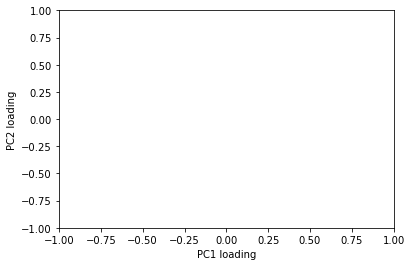

In [198]:
#Compute factor loadings
np.diag(val)
A = np.matmul(vec, np.diag(val)**0.5)

#Plot factor loadings
plt.figure()
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')

variables = ['temp', 'sal', 'do2', 'ph', 'fluor', 'ba', 'tide']
for i,txt in enumerate(variables):
    plt.plot([0,A[i,0]],[0,A[i,1]],'-')
    plt.text(A[i,0],A[i,1],txt)